In [1]:
import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM
import sklearn
from sklearn import preprocessing, model_selection
import tensorflow as tf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import string
from string import *
import pymongo
from collections import Counter

Using TensorFlow backend.


In [2]:
mc = pymongo.MongoClient()
db = mc['allrecipes']
recipes_coll = db['recipes']

In [112]:
soup_recipes = []
for recipe in recipes_coll.find():
    if recipe['category']['lvl_1'] == 'Soups, Stews and Chili':
        soup_recipes.append(recipe)
len(soup_recipes)

1136

In [113]:
recipes = list(recipes_coll.find())
ingredients = Counter()
for recipe in recipes:
    for ing in recipe['ingredients'].keys():
        ingredients[ing] += 1
print('Number of unique ingredients :', len(ingredients))

Number of unique ingredients : 2604


In [114]:
common_ingredients = []
for item, count in ingredients.most_common():
    if count > 4:
        common_ingredients.append(item)
print('Number of common ingredients :', len(common_ingredients))

Number of common ingredients : 521


In [130]:
def get_label_names(recipes, cat_lvl=2):
    labels = []
    key = 'lvl_{}'.format(cat_lvl)
    for recipe in recipes:
        labels.append(recipe['category'][key])
    return labels

def get_label_numbers(label_names, limit=None):
    ordered_names = [key for key, val in Counter(label_names).most_common()]
    label_nums = [ordered_names.index(label) for label in label_names]
    if not limit:
        return label_nums
    else:
        return [num if num < limit-1 else limit-1 for num in label_nums]

In [72]:
def create_dataframe(recipes, cutoff=2):
    recipe_ids = _get_recipe_ids(recipes)
    common_ingredients = _get_common_ingredients(recipes, cutoff=cutoff)
    df = pd.DataFrame(columns=common_ingredients, index=recipe_ids).fillna(0)
    unknown_servings = []
    for recipe in recipes:
        idx = recipe['id']
        servings = recipe['directions']['servings']
        if not servings:
            unknown_servings.append(recipe)
            #print('Servings missing')
            continue
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    # Determine approx servings for recipes where it is not specified
    for recipe in unknown_servings:
        servings = _approximate_servings(recipe, df)
        recipe['directions']['approx_servings'] = servings
    # Apply approx servings to recipes and insert data into dataframe
    for recipe in unknown_servings:
        servings = recipe['directions']['approx_servings']
        for ing, qty in recipe['ingredients'].items(): 
            norm_qty = qty['normalized_qty']
            if ing in df.columns:
                df.loc[idx, ing] = norm_qty / servings
    return df

def _get_recipe_ids(recipes):
    recipe_ids = []
    for recipe in recipes:
        recipe_ids.append(recipe['id'])
    return recipe_ids

def _approximate_servings(recipe, df):
    recipe_qtys = []
    df_means = []
    for ing, qty in recipe['ingredients'].items():
        if ing in df.columns:
            recipe_qtys.append(qty['normalized_qty'])
            ing_vals = df[df[ing] != 0][ing]
            df_means.append(np.mean(ing_vals))
    qtys_array = np.array(recipe_qtys)
    df_means_array = np.array(df_means)
    count = 1
    while True:
        err = np.mean(abs(qtys_array/count - df_means_array)) * count
        next_err = np.mean(abs(qtys_array/(count+1) - df_means_array)) * (count+1)
        if next_err > err:
            return count
        count += 1
        err = next_err
        
def _get_common_ingredients(recipes, cutoff=2):
    ingredients = Counter()
    for recipe in recipes:
        for ing in recipe['ingredients'].keys():
            ingredients[ing] += 1
    #print('Number of unique ingredients :', len(ingredients))
    common_ingredients = []
    for item, count in ingredients.most_common():
        if count >= cutoff:
            common_ingredients.append(item)
    #print('Number of common ingredients :', len(common_ingredients))
    return common_ingredients

In [115]:
soup_df = create_dataframe(soup_recipes, cutoff=5)

In [116]:
soup_df.shape

(1136, 287)

In [117]:
n_features = soup_df.shape[1]
model3 = Sequential()
model3.add(Dense(100,  activation='relu', input_shape=(n_features,)))
#model3.add(Dense(100,  activation='relu'))
model3.add(Dense(30,  activation='relu'))
model3.add(Dense(10,  activation='relu'))
model3.add(Dense(3,    activation='linear', name="bottleneck"))
model3.add(Dense(10,  activation='relu'))
model3.add(Dense(30,  activation='relu'))
model3.add(Dense(100,  activation='relu'))
#model3.add(Dense(300,  activation='relu'))
model3.add(Dense(n_features,  activation='linear'))
model3.compile(loss='mean_squared_error', optimizer = 'adam')

In [118]:
X = soup_df.values
means = np.mean(soup_df, axis=0)
stds = np.std(soup_df, axis=0)
df_scaled = (soup_df - means) / stds
X_scaled = df_scaled.values

In [135]:
label_names = get_label_names(soup_recipes)
label_nums = get_label_numbers(label_names)

In [122]:
history = model3.fit(X_scaled, X_scaled, batch_size=200, epochs=1000, verbose=None)

In [123]:
encoder3D = Model(model3.input, model3.get_layer('bottleneck').output)
z_enc = encoder3D.predict(X_scaled)

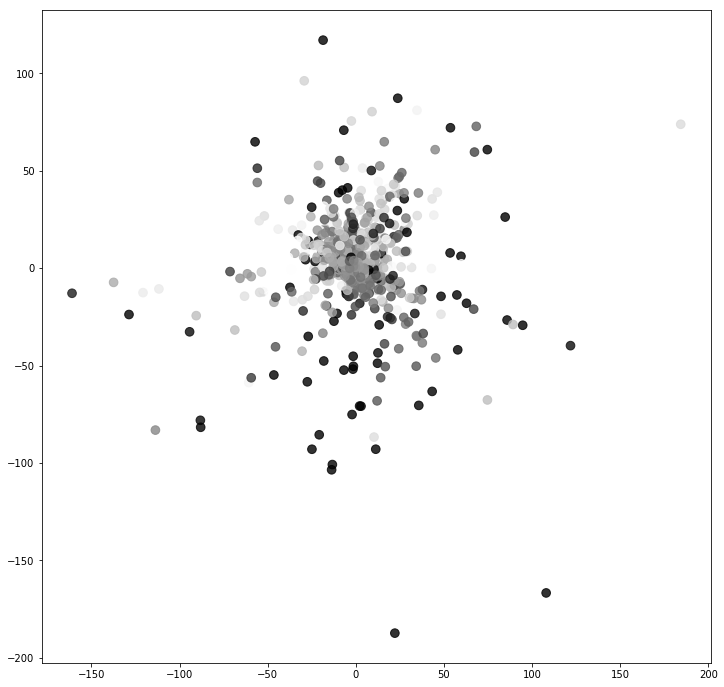

In [127]:
fig, ax = plt.subplots(1,1,figsize=(12, 12))

mean_0 = np.mean(z_enc[:,0])
std_0 = np.std(z_enc[:,0])
mean_1 = np.mean(z_enc[:,1])
std_1 = np.std(z_enc[:,1])
mean_2 = np.mean(z_enc[:,2])
std_2 = np.std(z_enc[:,2])
color = [cm.Greys((val-(mean_2)) / (3*std_2) + 0.5) for val in z_enc[:,2]]
z0 = z_enc[:, 0]
z1 = z_enc[:, 1]
ax.scatter(z0, z1, color=color, s=75, alpha=0.8)
#ax.set_yticklabels([])
#ax.set_xticklabels([])

#ax.set_xlim(left=-20, right=20)
#ax.set_ylim(bottom=-20, top=20)


In [128]:
model2 = Sequential()
model2.add(Dense(100,  activation='relu', input_shape=(n_features,)))
#model2.add(Dense(100,  activation='relu'))
model2.add(Dense(30,  activation='relu'))
model2.add(Dense(10,  activation='relu'))
model2.add(Dense(2,    activation='linear', name="bottleneck"))
model2.add(Dense(10,  activation='relu'))
model2.add(Dense(30,  activation='relu'))
model2.add(Dense(100,  activation='relu'))
#model2.add(Dense(300,  activation='relu'))
model2.add(Dense(n_features,  activation='linear'))
model2.compile(loss='mean_squared_error', optimizer = 'adam')

In [152]:
history = model2.fit(X_scaled, X_scaled, batch_size=60, epochs=1000, verbose=None)

(-50, 100)

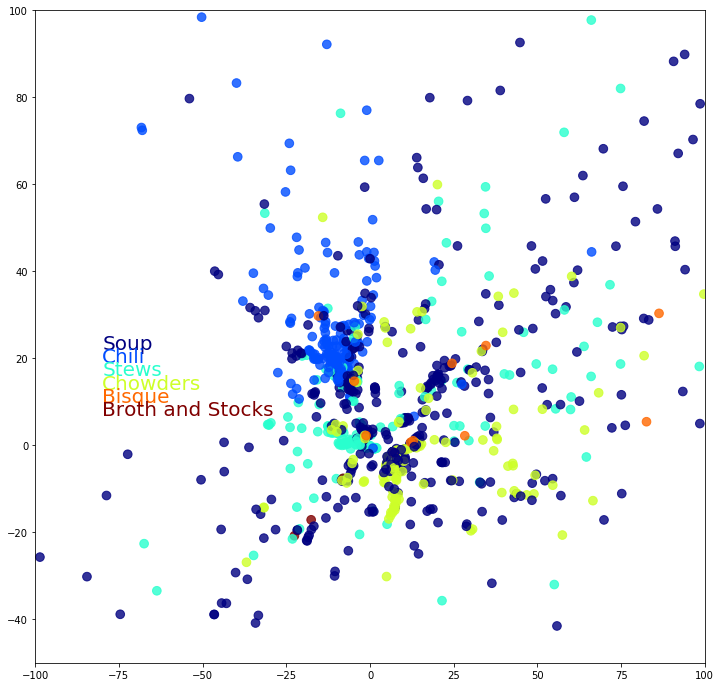

In [141]:
encoder2D = Model(model2.input, model2.get_layer('bottleneck').output)
z_enc = encoder2D.predict(X_scaled)
colors = [cm.jet(i/5) for i in label_nums]
ordered_names = [key for key, val in Counter(label_names).most_common()]
fig, ax = plt.subplots(1,1,figsize=(12, 12))
mean_0 = np.mean(z_enc[:,0])
std_0 = np.std(z_enc[:,0])
mean_1 = np.mean(z_enc[:,1])
std_1 = np.std(z_enc[:,1])
z0 = z_enc[:, 0]
z1 = z_enc[:, 1]
ax.scatter(z0, z1, color=colors, s=75, alpha=0.8)
ax.text(-80, 22, ordered_names[0], color=cm.jet(0), fontsize=20)
ax.text(-80, 19, ordered_names[1], color=cm.jet(1/5), fontsize=20)
ax.text(-80, 16, ordered_names[2], color=cm.jet(2/5), fontsize=20)
ax.text(-80, 13, ordered_names[3], color=cm.jet(3/5), fontsize=20)
ax.text(-80, 10, ordered_names[4], color=cm.jet(4/5), fontsize=20)
ax.text(-80, 7, ordered_names[5], color=cm.jet(1.0), fontsize=20)
#ax.set_yticklabels([])
#ax.set_xticklabels([])
ax.set_xlim(left=-100, right=100)
ax.set_ylim(bottom=-50, top=100)

In [145]:
lvl_3_labels = get_label_names(soup_recipes, 3)
categories = [key for key, val in Counter(lvl_3_labels).most_common()]

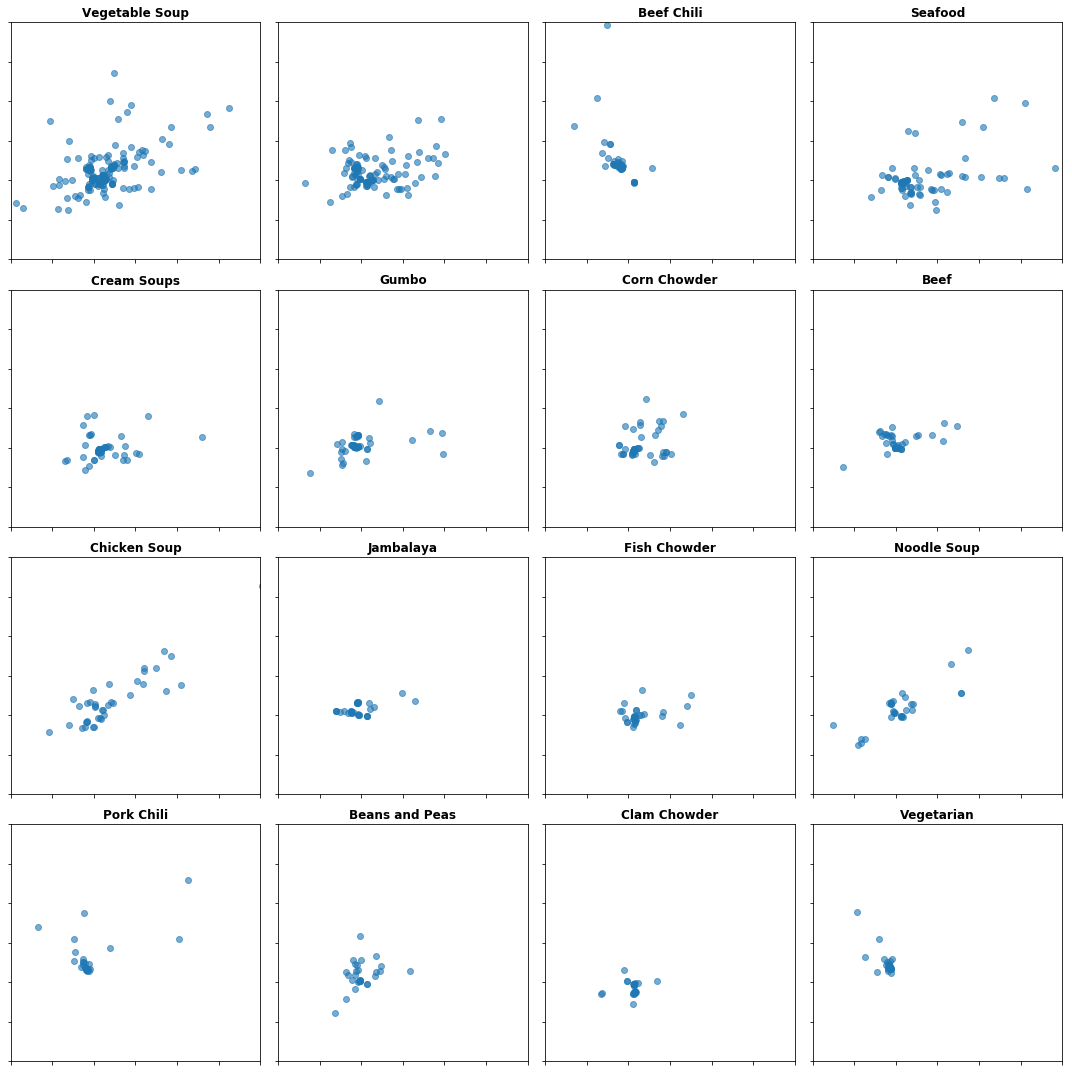

In [153]:
fig, axs = plt.subplots(4, 4,figsize=(15, 15), sharex=True, sharey=True)
z_enc = encoder2D.predict(X_scaled)
for i, ax in enumerate(axs.flatten()):
    mask = [recipe['category']['lvl_3']==categories[i] for recipe in soup_recipes]
    z0 = z_enc[mask, 0]
    z1 = z_enc[mask, 1]
    ax.scatter(z0, z1, alpha=0.6)
    ax.set_title(categories[i], fontweight='bold')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(left=-100, right=200)
    ax.set_ylim(bottom=-100, top=200)
fig.tight_layout()

In [146]:
mask = [recipe['category']['lvl_3']==categories[1] for recipe in soup_recipes]

array([[ 0.37254026,  1.96364665,  0.93623439, ..., -0.05557089,
        -0.04957431, -0.05687032],
       [-1.10175278, -0.63287772,  0.55848843, ..., -0.05557089,
        -0.04957431, -0.05687032],
       [ 2.68928647,  0.47991844, -0.57474943, ..., -0.05557089,
        -0.04957431, -0.05687032],
       ...,
       [-1.10175278, -0.30831217, -0.57474943, ..., -0.05557089,
        -0.04957431, -0.05687032],
       [ 0.66739887,  2.48295153, -0.57474943, ..., -0.05557089,
        -0.04957431, -0.05687032],
       [-0.73317952, -0.63287772, -0.57474943, ..., -0.05557089,
        -0.04957431, -0.05687032]])